In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1) Какой дополнительный функционал для аугментации в сравнении со встроенным аугментатором данных в Keras дают библиотеки [imgaug](https://github.com/aleju/imgaug) и [albumentations](https://github.com/albumentations-team/albumentations) ? 
В качестве ответа приведите в отчете примеры 5 функций и описание кейсов, в которых на ваш взгляд этот функционал был бы полезен.

Рассмотрим следующую таблицу:
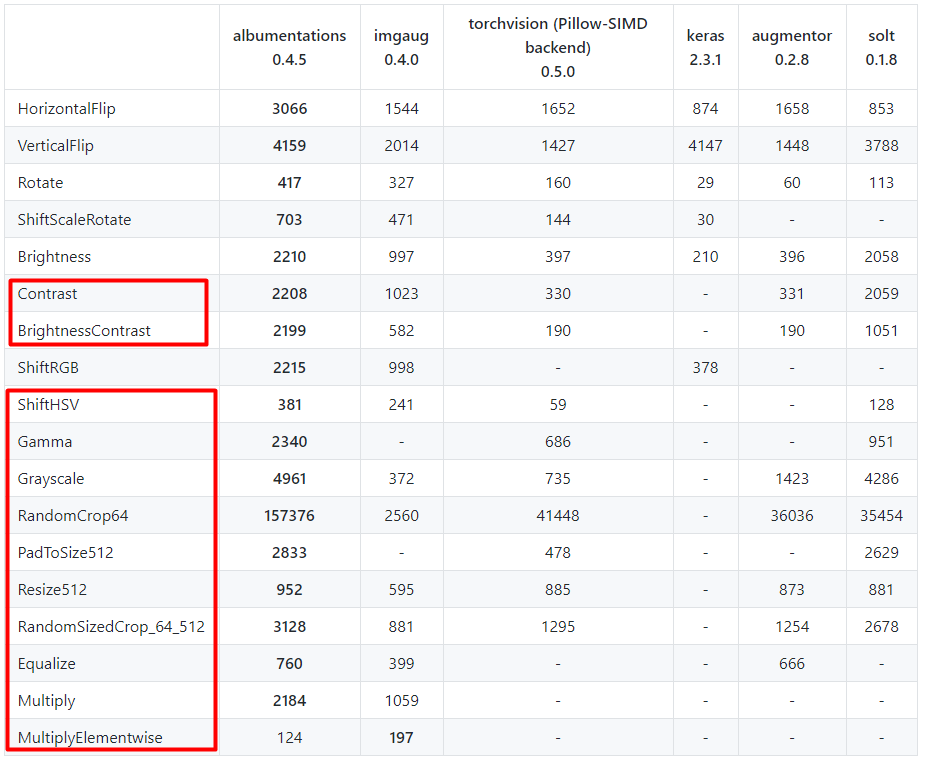

Красным выделены функции из дополнительных библиотек, аналогов которым нет во встроенном аугментаторе данных Keras.

#### a) Grayscale.
Относится к попиксельным изменениям изображения.
Значение каждого пикселя представляет собой один образец, представляющий только количество света; то есть он несет только информацию об интенсивности, убирая цветовой компонент.

Сильно упрощает модель (сводит к одному каналу вместо трех-четырех). К тому же, обычно основная информация как раз выражена в световом компоненте, а не в цветовом.

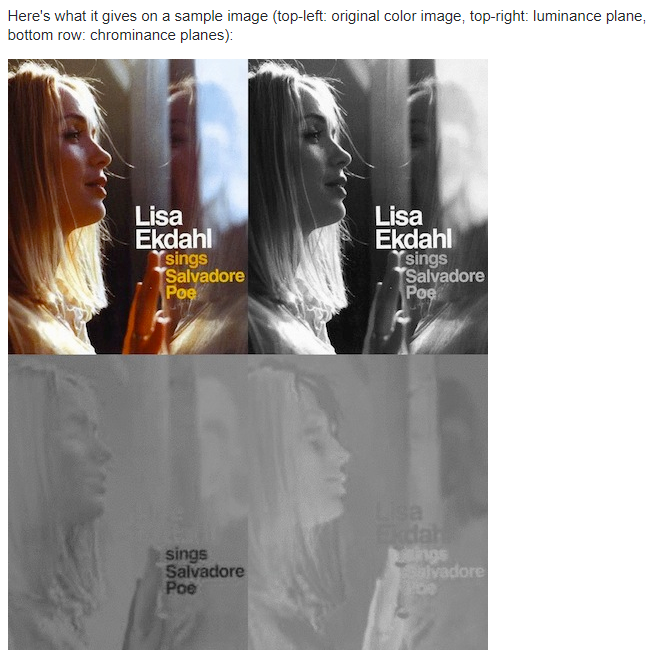

#### b) LinearContrast

Попиксельное изменение контрастности, масштабируя каждый пиксель по формуле
127 + альфа * (v-127).

Хорошо подходит, например, для выделения человеческой фигуры на светлом фоне.

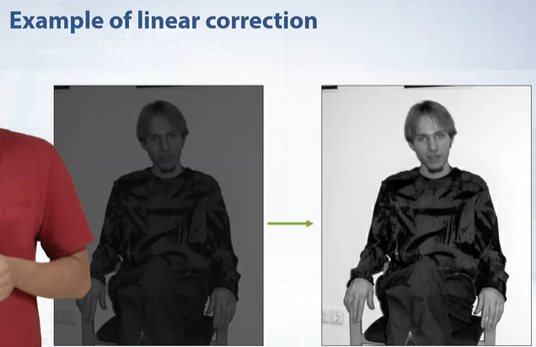

#### c) Gamma

Попиксельное изменение контрастности, но несколько по другому правилу, нежели линейное: 255((v/255)*gamma)

Линейное изменение контрастности плохо подходит для некоторых изображений, для которых гамма показывает гораздо лучший результат.

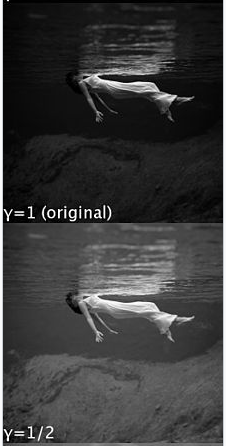

#### d) Multiply.
Умножает все пиксели на изображении, выбрав случайное значение один раз для каждого изображения. Этот функционал можно использовать для того, чтобы сделать изображение светлее или темнее.

Хорошо подходит для многих задач, где нужно расширение тренировочной выборки, поскольку незначительно затемняет/осветляет изображение, что может соответствовать фотоснимку объекта при несколько другом освещении.

#### e) MultiplyElementwise.

Умножает все пиксели изображения на значения, которые отбираются случайным образом для каждого пикселя и изображения.
Незначительно отличается от Multiply, однако, дает более случайную картину на выходе.

### 2) Посмотрите примеры предобученных сетей по [cсылке](https://keras.io/applications/). 
Загрузите любую из них и сохраните в формате h5.<br>
Визуализируйте, отличную от VGG, сеть с помощью [netron](https://lutzroeder.github.io/netron/) - [github](https://github.com/lutzroeder/netron). 
Вставьте в отчет скриншот с графом выбранной вами сети.

In [0]:
# from tensorflow.keras.applications import NASNetMobile

# model = NASNetMobile()
# model.save('NASNetMobile.h5')

Сеть довольно глубокая, скриншот добавлять неудобно. Частично скриншоты добавлены в пункте с разморозкой слоев.
Полный граф прикреплен к отчету отдельным файлом.

### 3.1) Примените техники [fine tuning / transfer learning](https://habr.com/ru/company/microsoft/blog/314934/) для решения задачи на Kaggle.
 Возьмите одну из предобученных сетей, удалите классификационную часть, заметите своей и попробуйте обучить, используя предобученную сеть с готовыми весами как feature extractor. 
 Для этого все слои преобученной сети надо заморозить (установить этим слоям параметр trainable=false). Отразите в отчете, какой точности удается добиться?

In [0]:
import pandas as pd
import numpy as np
import time

from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import NASNetMobile, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, RMSprop
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping

In [0]:
data_path = '/content/drive/My Drive/Colab Notebooks/hotdogornot/'

train_path = data_path + 'train/train_kaggle/'
test_path = data_path + 'test/'
sample_path = data_path + 'sample_submission.csv'
train_split_path = train_path+"_split"

In [0]:
#!cd "$train_path" && mkdir label1 label0 && mv food* furniture* people* pets* label0 && mv frankfurter* chili-dog* hotdog* label1

In [0]:
#! pip install split-folders tqdm
#! split_folders "$train_path" --ratio .8 .2 --output "$train_split_path"

In [0]:
train_split = train_split_path+"/train"
val_split = train_split_path+"/val"

In [0]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [38]:
train_data_flow = train_datagen.flow_from_directory(
    directory=train_split,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=42,
)

val_data_flow = validation_datagen.flow_from_directory(
    directory=val_split,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=42,
)

Found 3682 images belonging to 2 classes.
Found 921 images belonging to 2 classes.


In [0]:
# create the base pre-trained model
base_model = NASNetMobile(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=RMSprop(lr=2e-5), loss='binary_crossentropy', metrics = ['accuracy'])

In [0]:
epochs = 30
verbose = 1

In [0]:
def train_model(model):
  start = time.time()
  h = model.fit(train_data_flow,
                validation_data=val_data_flow,
                epochs=epochs, verbose=verbose, 
                use_multiprocessing=True, workers=6 
                )
  print("Epochs={0:d}, Train accuracy={1:.5f}, Validation accuracy={2:.5f}, Training time={3:.2f} minutes"
                .format(epochs, 
                        max(h.history['accuracy']), 
                        max(h.history['val_accuracy']), 
                        (time.time()-start)/60))
  return model

In [0]:
def get_predictions(trained_model, file_num=0):
  test_datagen = ImageDataGenerator(rescale=1./255)
  test_generator = test_datagen.flow_from_directory(
      test_path,
      target_size=(224, 224),
      color_mode="rgb",
      shuffle=False,
      batch_size=1,
      class_mode='binary',
  )

  predict = trained_model.predict(test_generator, steps = test_generator.n, verbose=verbose)
  labels = (predict > 0.5).astype(np.int)
  sample_df = pd.read_csv(sample_path)
  sample_df['label'] = labels
  submission_file_name = 'sample_submission_{0}.csv'.format(file_num)
  sample_df.to_csv(submission_file_name, index=False)

In [0]:
# trained_model = train_model(model)
# get_predictions(trained_model)

Точность на Kaggle:
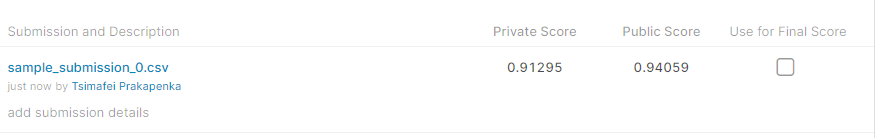

### - 3.2) Попробуйте постепенно размораживать слои или блоки. Растет ли точность?

In [44]:
concat_layers_indices = []
for i, layer in enumerate(model.layers):
  if 'concat' in layer.name and i > 600:
    concat_layers_indices.append(i+1)
    print(i, layer.name)

632 normal_concat_9
677 normal_concat_10
722 normal_concat_11
767 normal_concat_12


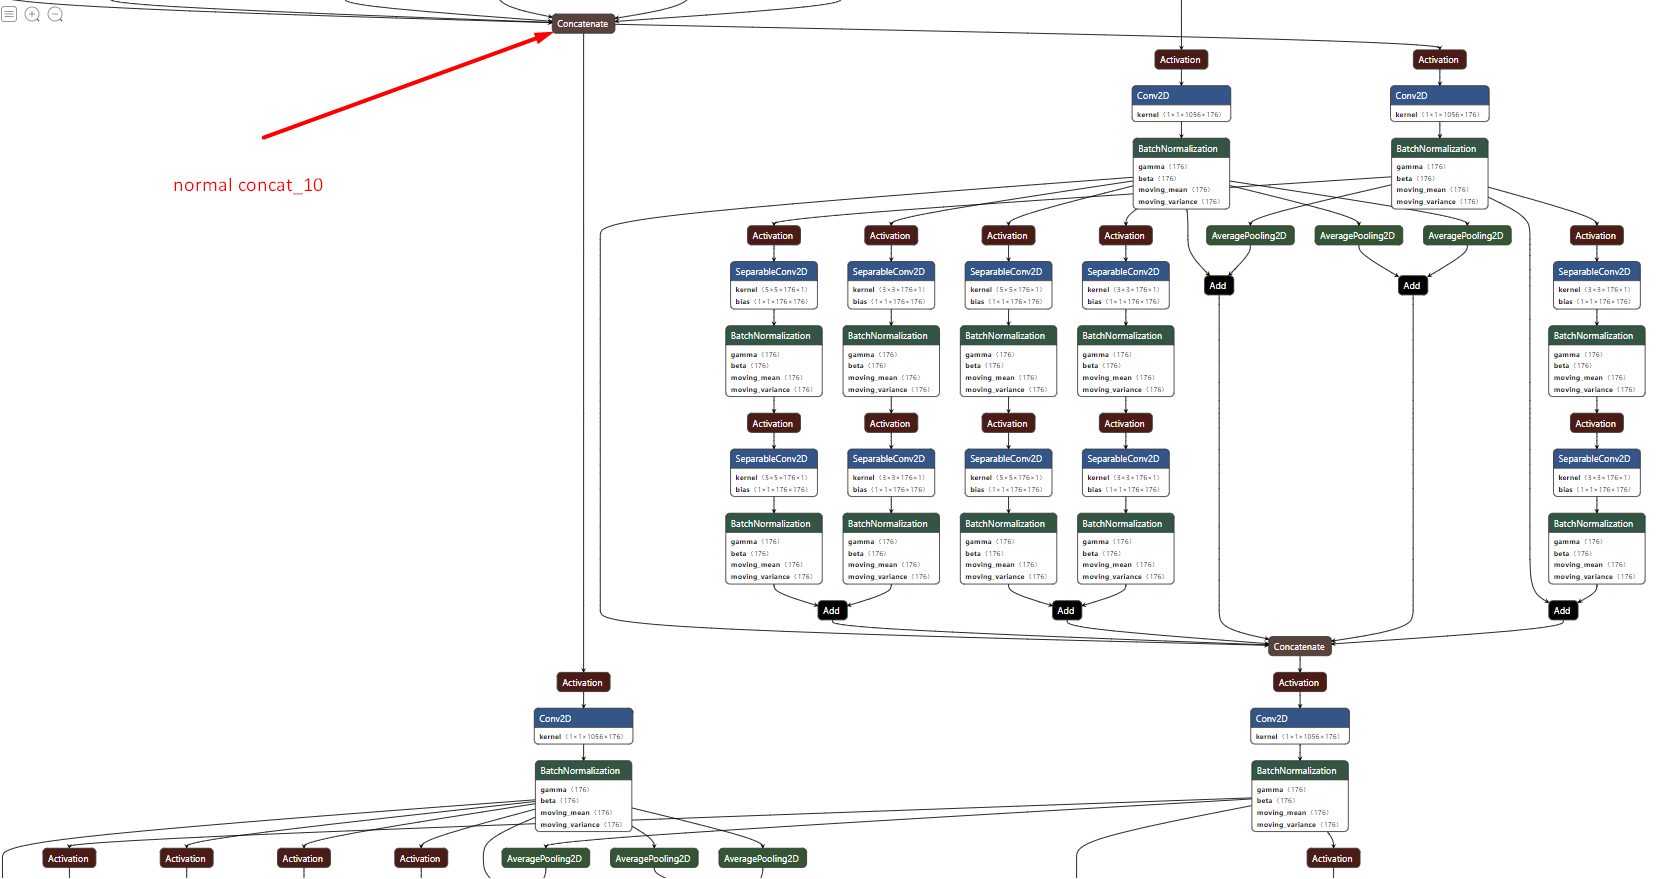

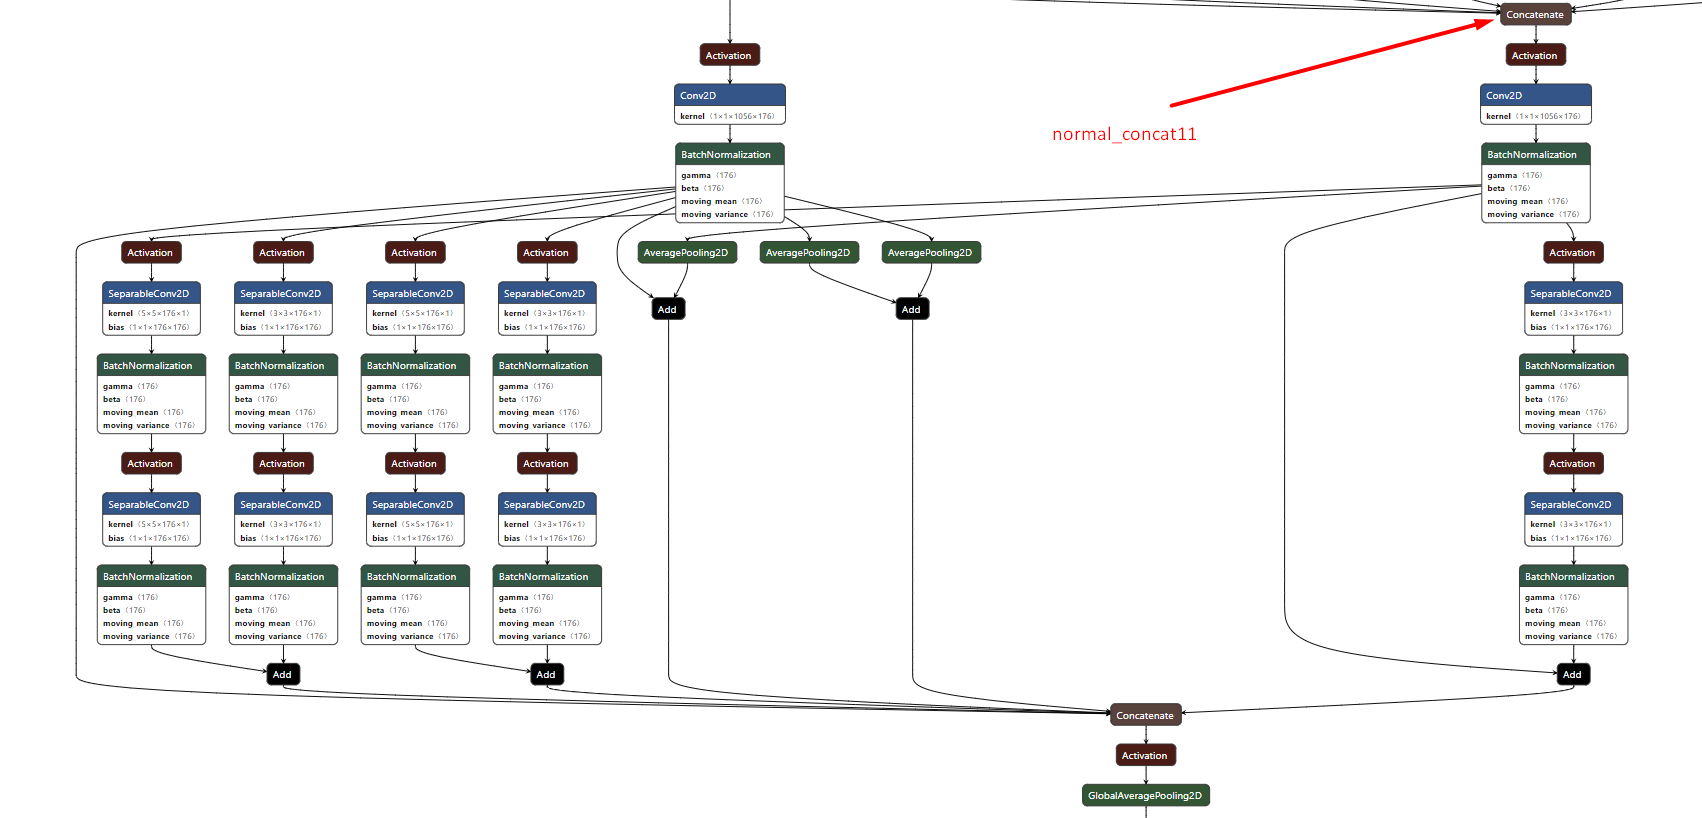

#### First test model

In [0]:
for layer in model.layers[:concat_layers_indices[-1]]:
   layer.trainable = False
for layer in model.layers[concat_layers_indices[-1]:]:
   layer.trainable = True

model.compile(optimizer=RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
#trained_model = train_model(model)

In [0]:
#get_predictions(trained_model, 1)

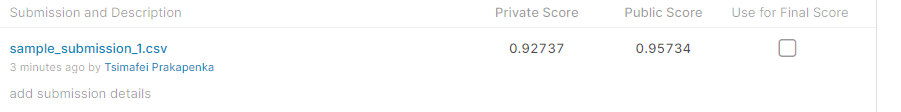

#### Second test model

In [0]:
for layer in model.layers[:concat_layers_indices[-2]]:
   layer.trainable = False
for layer in model.layers[concat_layers_indices[-2]:]:
   layer.trainable = True

model.compile(optimizer=RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
#trained_model = train_model(model)

In [0]:
#get_predictions(trained_model, 2)

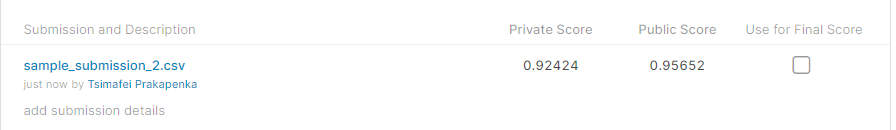

#### Вывод
При размораживании верхних слоев растет точность, так как мы начинаем больше обучать модель под свою задачу, нежели пользуемся предобученной частью.

### 4) Реализуйте свой генератор данных с аугментациями на ваш выбор. Обоснуйте применяемые аугментации.

In [51]:
dummy_datagen = ImageDataGenerator()
train_data_flow = dummy_datagen.flow_from_directory(directory=train_split)
val_data_flow = dummy_datagen.flow_from_directory(directory=val_split)

Found 3682 images belonging to 2 classes.
Found 921 images belonging to 2 classes.


In [52]:
partition = {}
partition['train'] = [x.split('/')[1] for x in train_data_flow.filenames]
partition['val'] = [x.split('/')[1] for x in val_data_flow.filenames]
all_files = train_data_flow.filenames[:]
all_files.extend(val_data_flow.filenames)
labels = {x.split('/')[1]:x.split('/')[0][-1] for x in all_files}
print(len(labels))

image_paths_train = {x.split('/')[1]:train_data_flow.directory+'/'+x for x in train_data_flow.filenames}
image_paths_val = {x.split('/')[1]:val_data_flow.directory+'/'+x for x in val_data_flow.filenames}

4603


In [0]:
class MyDataGenerator(Sequence):
    def __init__(self, list_IDs, labels, image_paths, dim, augmentations=None,
                 batch_size=32, n_channels=1, shuffle=True):
        self.dim = dim
        self.augment = augmentations
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.image_paths = image_paths
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        
        return np.stack([self.augment(image=x)["image"] for x in X], axis=0), y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        for i, ID in enumerate(list_IDs_temp):
            image = load_img(self.image_paths[ID], target_size=self.dim)
            X[i,] = img_to_array(image)

            y[i] = self.labels[ID]

        return X, y

In [0]:
from albumentations import (
    Compose, HorizontalFlip,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightness(limit=0.2, p=0.5),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=15, p=0.8), 
    ToFloat(max_value=255)
])

AUGMENTATIONS_VAL = Compose([
    ToFloat(max_value=255)
])

#### Обоснование приведенных аугументаций:

1) HorizontalFlip - полезен конкретно для нашей задачи, так как хотдог может находится на картинке в любом месте и под любым углом.

2) RandomContrast, RandomGamma, RandomBrightness - имитирует возможное изменение освещения, контрастности изображения и, например, позволяют не переобучиваются для конкретной модели фотоаппарата, делавшего снимки для датасета.

3) ShiftScaleRotate - набор афинных преобразований, которые преобразуют изображение не очень сильно. Позволяет добиться расширения датасета довольно естественными изображениями.

4) ToFloat - нормализация входного изображения.

#### Проверка работоспособности самописного генератора данных:

In [55]:
epochs = 1
verbose = 1

params = {'dim': (224, 224),
          'batch_size': 32,
          'n_channels': 3,
          'shuffle': True}

training_generator = MyDataGenerator(partition['train'], labels, image_paths_train, augmentations=AUGMENTATIONS_TRAIN, **params)
validation_generator = MyDataGenerator(partition['val'], labels, image_paths_val, augmentations=AUGMENTATIONS_VAL, **params)

h = model.fit(
    training_generator, 
    validation_data=validation_generator,
    epochs=epochs, verbose=verbose)

115/115 [==============================] - 67s 584ms/step - loss: 0.5934 - accuracy: 0.7019 - val_loss: 0.4093 - val_accuracy: 0.9096


### 5) Попробуйте добиться максимальной точности классификации на Kaggle с помощью нейронной сети, состоящей не более, чем из 5 миллионов параметров. 
Отразите в отчете точность вашей модели и количество параметров (весов).

Лучшая точность получилась на одной из моделей, обученной для предыдущих пунктов (на основе NASNetMobile с разморозкой верхних слоев):

In [56]:
model.count_params()

4811413

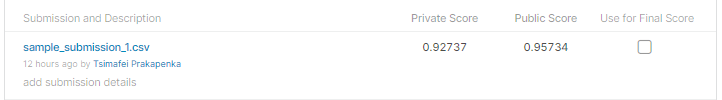